In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import db_connection as db

In [36]:
# load your cleaned flight log
df = db.read_db("flights_cleaned")
df.head()

,latitude,longitude,datetime,gps_altitude_m,distance_m,speed_km/s,climb_m,climb_m(delta),climb_rate_m/s,glide_ratio,bearing,delta_bearing,elapsed_time,delta_time,temp,pressure,humidity,dew_point,wind_speed,wind_deg
0,36.980983,29.314417,2020-07-03 07:42:24,2083,7.545830,27.164986,-2.0,0.0,-2.0,3.772915,11,3.0,17.0,1.0,25.62,1008.0,35.0,9.04,0.66,75.0
1,36.981050,29.314450,2020-07-03 07:42:25,2082,7.971536,28.697530,-3.0,0.0,-3.0,2.657179,21,10.0,18.0,1.0,25.62,1008.0,35.0,9.04,0.66,75.0
2,36.981150,29.314500,2020-07-03 07:42:26,2080,11.957302,43.046289,-2.0,0.0,-2.0,5.978651,21,0.0,19.0,1.0,25.62,1008.0,35.0,9.04,0.66,75.0
3,36.981217,29.314567,2020-07-03 07:42:27,2079,9.485179,34.146645,-1.0,-14.0,-1.0,9.485179,38,17.0,20.0,1.0,25.62,1008.0,35.0,9.04,0.66,75.0
4,36.981283,29.314633,2020-07-03 07:42:28,2078,9.485176,34.146634,0.0,-14.0,0.0,0.000000,38,0.0,21.0,1.0,25.62,1008.0,35.0,9.04,0.66,75.0


In [37]:
feature_cols = [
    'gps_altitude_m', 'distance_m', 'speed_km/s',
    'glide_ratio', 'bearing', 'delta_bearing',
    'temp', 'pressure', 'humidity', 'dew_point',
    'wind_speed', 'wind_deg'
]
X = df[feature_cols].values
y = df['climb_rate_m/s'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

In [38]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print("LR MAE:", mean_absolute_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
print("LR MSE:", mse)
rmse = np.sqrt(mse)
print("LR RMSE:", rmse)
r2_alt = lr.score(X_test, y_test)
print("LR R²:", r2_alt)

LR MAE: 1.5539510571654098
LR MSE: 3.8221402534468383
LR RMSE: 1.9550294763626552
LR R²: 0.16583722994065786


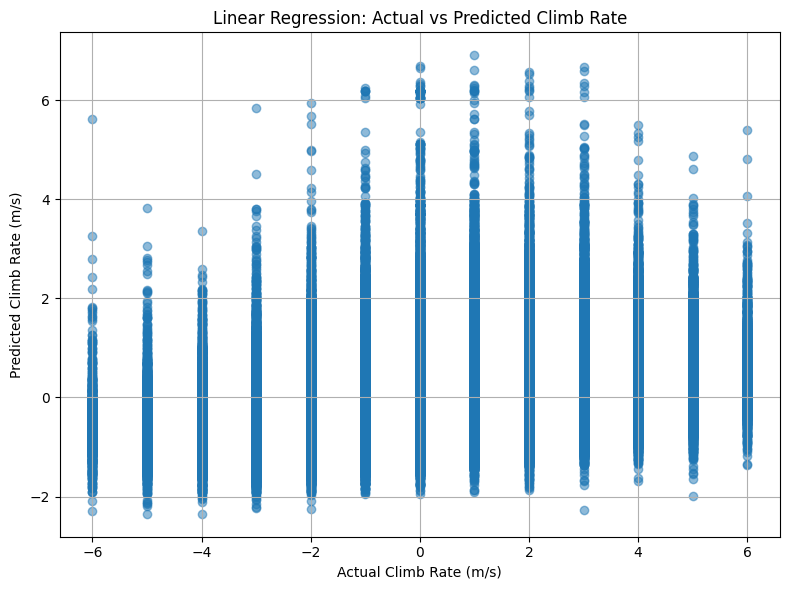

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Climb Rate (m/s)')
plt.ylabel('Predicted Climb Rate (m/s)')
plt.title('Linear Regression: Actual vs Predicted Climb Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


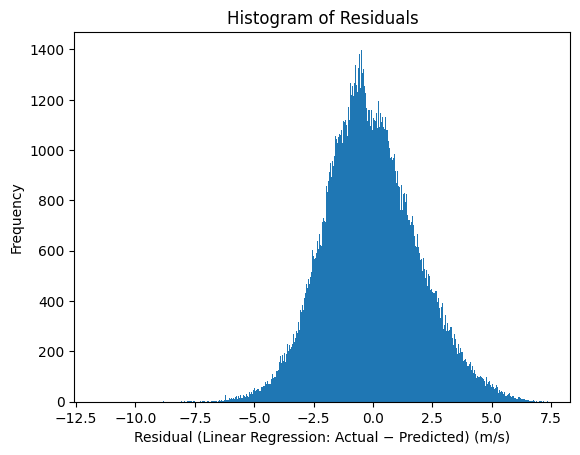

In [40]:
residuals = y_test - y_pred
plt.figure()
plt.hist(residuals, bins=1000)
plt.xlabel("Residual (Linear Regression: Actual − Predicted) (m/s)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()



In [41]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("RF MAE:", mean_absolute_error(y_test, y_pred_rf))
mse = mean_squared_error(y_test, y_pred)
print("RF MSE:", mse)
rmse = np.sqrt(mse)
print("RF RMSE:", rmse)
r2_alt = lr.score(X_test, y_test)
print("RF R²:", r2_alt)


RF MAE: 1.096344575464544
RF MSE: 3.8221402534468383
RF RMSE: 1.9550294763626552
RF R²: 0.16583722994065786


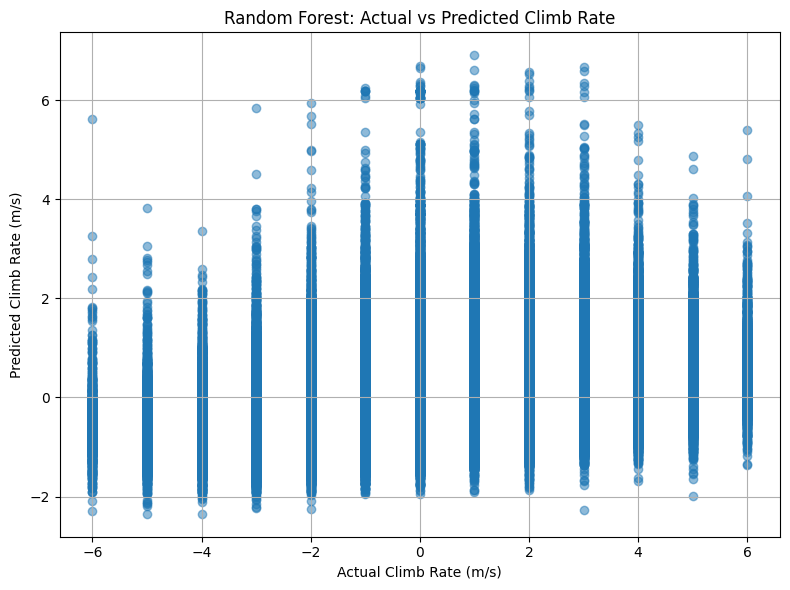

In [42]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Climb Rate (m/s)')
plt.ylabel('Predicted Climb Rate (m/s)')
plt.title('Random Forest: Actual vs Predicted Climb Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


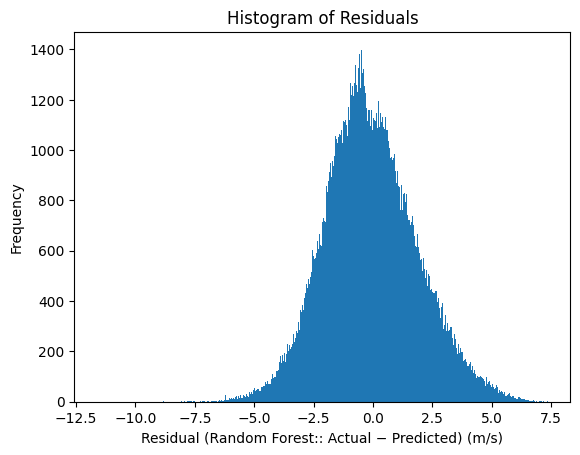

In [43]:
residuals = y_test - y_pred
plt.figure()
plt.hist(residuals, bins=1000)
plt.xlabel("Residual (Random Forest:: Actual − Predicted) (m/s)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


In [44]:
# Create sliding windows of length T
def create_sequences(X, y, T=10):
    Xs, ys = [], []
    for i in range(len(X) - T):
        Xs.append(X[i:i+T])
        ys.append(y[i+T])
    return np.array(Xs), np.array(ys)

T = 20  # e.g., previous timesteps
X_seq, y_seq = create_sequences(X_scaled, y, T)

# Split
split = int(0.8 * len(X_seq))
X_tr, X_val = X_seq[:split], X_seq[split:]
y_tr, y_val = y_seq[:split], y_seq[split:]

# Build LSTM
model = Sequential([
    LSTM(64, input_shape=(T, X_scaled.shape[1]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[es]
)


e:\Wolf\Belgeler\Projelerim\Paragliding_Flight_Analyses\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 131s 6ms/step - loss: 1.9129 - mae: 1.0258 - val_loss: 1.5992 - val_mae: 0.9223
Epoch 2/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 112s 6ms/step - loss: 1.2900 - mae: 0.8405 - val_loss: 1.5712 - val_mae: 0.9045
Epoch 3/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 120s 6ms/step - loss: 1.2223 - mae: 0.8208 - val_loss: 1.5533 - val_mae: 0.8975
Epoch 4/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 124s 7ms/step - loss: 1.1833 - mae: 0.8101 - val_loss: 1.5627 - val_mae: 0.9024
Epoch 5/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 112s 6ms/step - loss: 1.1597 - mae: 0.8025 - val_loss: 1.5471 - val_mae: 0.8942
Epoch 6/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 112s 6ms/step - loss: 1.1405 - mae: 0.7972 - val_loss: 1.5858 - val_mae: 0.9049
Epoch 7/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 113s 6ms/step - loss: 1.1251 - mae: 0.7933 - val_loss: 1.5659 - val_mae: 0.8974
Epoch 8/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 116s 6ms/step - loss: 1.1109 - mae: 0.7895 - val_loss: 1.6144 - val_mae: 0.9077
Epoch 9/

In [45]:
# Evaluate
mse, mae = model.evaluate(X_val, y_val)
print("LSTM MAE:", mae)
print("LSTM RMSE:", np.sqrt(mse))

9481/9481 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1.4070 - mae: 0.8666
LSTM MAE: 0.8942137360572815
LSTM RMSE: 1.2438154768841314


In [46]:
# 1. Generate predictions
y_pred = model.predict(X_val).flatten()
actual = y_val

# 2. Compute residuals
residuals = actual - y_pred


9481/9481 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


In [47]:
df_predict = pd.DataFrame({'Actual': actual, 'Predicted': y_pred, 'Residuals': residuals})
df_predict.head()

,Actual,Predicted,Residuals
0,1.0,0.491789,0.508211
1,1.0,0.855064,0.144936
2,1.0,1.279990,-0.279990
3,2.0,1.398461,0.601539
4,1.0,1.971094,-0.971094


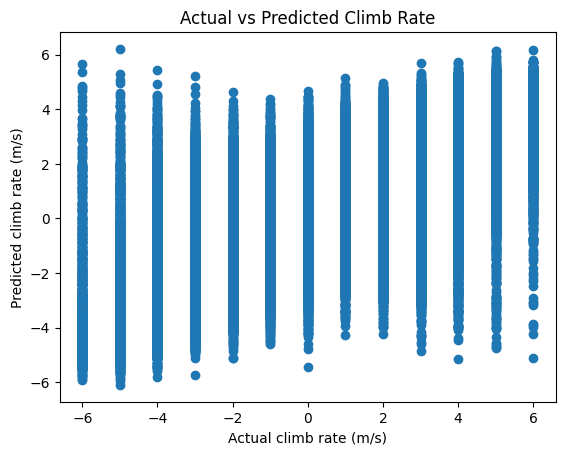

In [48]:

# 3. Scatter: actual vs. predicted
plt.figure()
plt.scatter(actual, y_pred)
plt.xlabel("Actual climb rate (m/s)")
plt.ylabel("Predicted climb rate (m/s)")
plt.title("Actual vs Predicted Climb Rate")
plt.show()


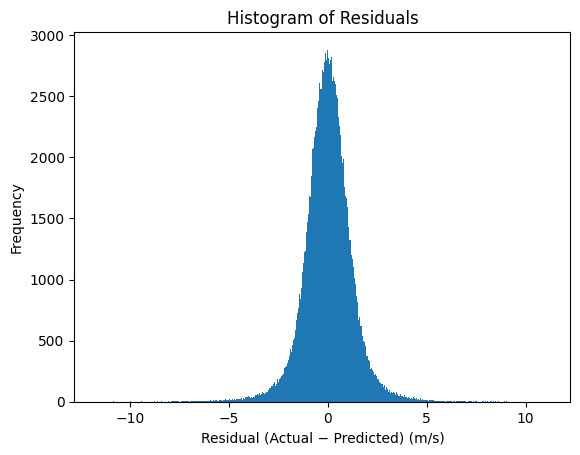

In [60]:
# 4. Histogram of residuals
plt.figure()
plt.hist(residuals, bins=1000)
plt.xlabel("Residual (Actual − Predicted) (m/s)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

In [50]:
# residuals = actual - y_pred from before
res_mean = np.mean(residuals)
res_std  = np.std(residuals)
print(f"Mean residual: {res_mean:.3f} m/s")
print(f"Residual STD : {res_std:.3f} m/s")

for thr in (0.5, 1.0, 2.0):
    pct = (np.abs(residuals) <= thr).mean() * 100
    print(f"% of errors within ±{thr:.1f} m/s: {pct:.1f}%")

Mean residual: 0.017 m/s
Residual STD : 1.244 m/s
% of errors within ±0.5 m/s: 38.6%
% of errors within ±1.0 m/s: 67.4%
% of errors within ±2.0 m/s: 91.4%


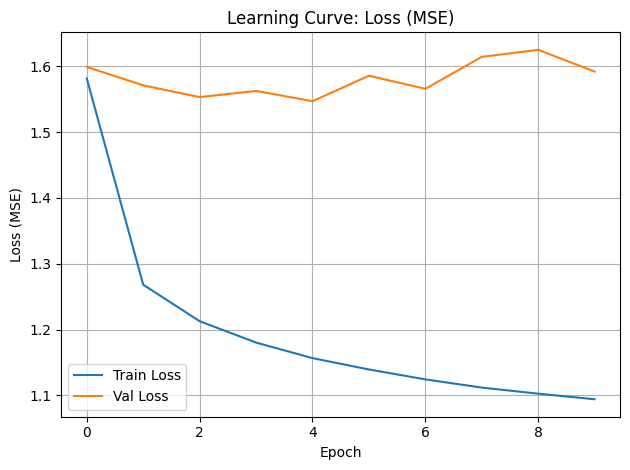

In [58]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Learning Curve: Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


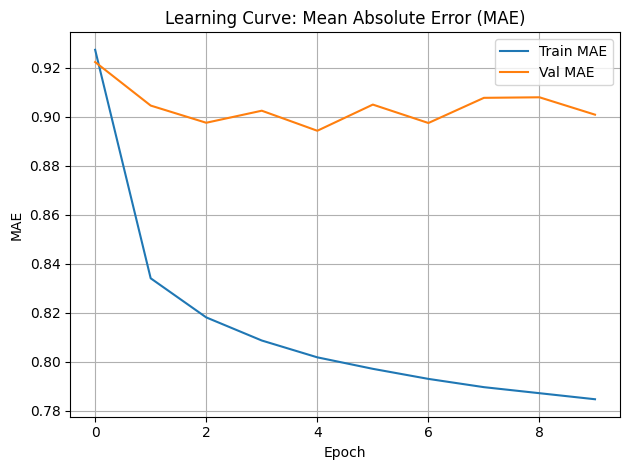

In [ ]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Learning Curve: Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
